In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First load in neural network

In [2]:
model_numpy=np.load("Neural/neural_model.npz")
w_array_0=np.matrix(model_numpy["w_array_0"])
b_array_0=np.matrix(model_numpy["b_array_0"])
w_array_1=np.matrix(model_numpy["w_array_1"])
b_array_1=np.matrix(model_numpy["b_array_1"])

In [3]:
# Input params:
xdata = np.load('../GibbsChem/Network Training Data/APOGEE Training Data.npz')
norm_params=xdata['norm_grid']

In [4]:
# Normalization Parameters
norm_means=xdata['means']
norm_widths=xdata['full_widths']

In [5]:
def neural_net(norm_params):
    if isinstance(norm_params[0],np.ndarray):
        n_stars=len(norm_params)
        layer1=np.matmul(norm_params,w_array_0.T)+np.matmul(np.matrix(np.ones(n_stars)).T,b_array_0)
        layer2=np.matmul(np.tanh(layer1),w_array_1.T)+np.matmul(np.matrix(np.ones(n_stars)).T,b_array_1)
    else: 
        layer1=np.dot(norm_params,w_array_0.T)+b_array_0
        layer2=np.dot(np.tanh(layer1),w_array_1.T)+b_array_1
    return(layer2)

### Read in APOGEE Data and Priors
- NB: Ages are in ln(years) here
- Priors are from Philcox+17

*This step is slightly unnecessary but could be useful if the prior means are not the same as the normalization means*

In [6]:
n_stars = 50
apogee=np.load('../GibbsChem/APOGEE_dataset.npz')
mu_ages = apogee['ln_age'][:n_stars]
sigma_ages = apogee['ln_age_err'][:n_stars]

In [7]:
# Proto-solar data
sol_data,sol_err=np.load('Chempy/input/stars/Proto-sun.npy')
sol_els = sol_data.dtype.names
sol_ages = np.log(sol_data[-1])
sol_sigma_ages = 1e-3#sol_err[-1]/sol_data[-1]

In [8]:
solar_abundances=[];solar_errors=[]
for name in apogee['names']:
    for i in range(len(sol_els)):
        if name.astype(str)==sol_els[i]:
            solar_abundances.append(sol_data[i])
            solar_errors.append(sol_err[i])

In [9]:
APOGEE_abundances=apogee['abun'][:n_stars]
APOGEE_errors=apogee['abun_err'][:n_stars]

In [57]:
# FOR TESTING
n_stars=1
mu_ages = [np.array(sol_ages)]
sigma_ages = [np.array(sol_sigma_ages)]
APOGEE_abundances=np.matrix(solar_abundances)
APOGEE_errors=np.matrix(solar_errors)

In [10]:
unnormalized_prior_means = norm_means[:5] 
unnormalized_prior_sigmas = norm_widths[:5]

In [11]:
# Read in priors:
Lambda_prior_mu = unnormalized_prior_means[:2]-norm_means[:2]
Lambda_prior_sigma = unnormalized_prior_sigmas[:2]/norm_widths[:2]
Theta_prior_mu = unnormalized_prior_means[2:5]-norm_means[2:5]
Theta_prior_sigma = unnormalized_prior_sigmas[2:5]/norm_widths[2:5]

# Define stacked local priors
Local_prior_mu = np.vstack([np.hstack([Theta_prior_mu,mu_ages[i]]) for i in range(n_stars)])
Local_prior_sigma = np.vstack([np.hstack([Theta_prior_sigma,sigma_ages[i]]) for i in range(n_stars)])

## Define Priors and Likelihoods

In [12]:
def neg_log_prior_global(Lambda):
    # Return prior for global parameters
    tmp = (Lambda-Lambda_prior_mu)/Lambda_prior_sigma
    return 0.5*np.sum(tmp**2.)
def neg_log_prior_local(Thetas,ages):
    # Return prior for local parameters
    # input is Thetas local variables, ages of stars
    # This returns a vector of priors for each star
    all_local=np.hstack([Thetas,ages])
    tmp = (all_local-Local_prior_mu)/Local_prior_sigma
    return 0.5*np.sum(np.square(tmp),axis=1)

In [13]:
def each_star_likelihood(Lambda,Thetas,ages):
    # Return negative log likelihood for each star
    Lambda_arr = np.vstack([Lambda for _ in range(len(ages))])
    prediction = neural_net(np.hstack([Lambda_arr,Thetas,ages]))
    true_data = APOGEE_abundances
    error = APOGEE_errors
    tmp = (prediction-true_data)/error
    return 0.5*np.sum(np.square(tmp),axis=1)
def all_star_likelihood(Lambda,Thetas,ages):
    # Return negative log likelihood for many stars
    predictions=neural_net(np.hstack([Lambda,Thetas,ages]))
    true_data = APOGEE_abundances
    error = APOGEE_errors
    temp_matrix = ((predictions-true_data)/error)
    return np.sum(np.matmul(temp_matrix,temp_matrix.T))

In [14]:
def Lambda_distribution(Lambda_new,Thetas,ages):
    # Probability distribution P(Lambda|Thetas,ages)
    # Returns negative log probability
    Lambda_array = np.matmul(np.matrix(np.ones(len(Thetas))).T,np.matrix(Lambda_new))
    return all_star_likelihood(Lambda_array,Thetas,ages)+neg_log_prior_global(Lambda_new)
def Local_distribution(Thetas_new,ages_new,Lambda):
    # Probability distribution P(Theta_j,age_j|Lambda) for star j
    # Returns negative log probability
    like=each_star_likelihood(Lambda,Thetas_new,ages_new)
    prior = neg_log_prior_local(Thetas_new,ages_new)
    return like+prior 

## Try PyMC3 Sampler

In [17]:
import theano.tensor as tt
Lambda_cov=np.diag(pow(Lambda_prior_sigma,2.))
Theta_cov = np.diag(pow(Theta_prior_sigma,2.))
Ages_cov = np.diag(pow(np.asarray(sigma_ages),2.))

data_obs = APOGEE_abundances.ravel()
data_cov = np.diag(pow(np.asarray(APOGEE_errors).ravel(),2.))

w0=tt._shared(w_array_0)
b0=tt._shared(b_array_0)
w1=tt._shared(w_array_1)
b1=tt._shared(b_array_1)
ones_tensor = tt.ones([n_stars,1])

In [18]:
import pymc3 as pm
import pymc3.math as ma
import theano.tensor as tt

model1=pm.Model()

with model1:
    # Define priors
    Lambda = pm.MvNormal('Lambda',mu=Lambda_prior_mu,cov=Lambda_cov,shape=(1,len(Lambda_prior_mu)))
    Thetas = pm.MvNormal('Thetas',mu=Theta_prior_mu,cov=Theta_cov,shape=(n_stars,len(Theta_prior_mu)))
    Ages = pm.MvNormal('Ages',mu=mu_ages,cov=Ages_cov,shape=(1,len(mu_ages)))
    
    # Define input parameter matrix
    Lambda_all = ma.matrix_dot(tt.ones([n_stars,1]),Lambda)
    InputVariables = ma.concatenate([Lambda_all,Thetas,Ages.T],axis=1)
    
    # Define neural network output
    layer1 = ma.matrix_dot(InputVariables,w0.T)+ma.matrix_dot(ones_tensor,b0)
    output = ma.matrix_dot(ma.tanh(layer1),w1.T)+ma.matrix_dot(ones_tensor,b1)
    
    # Define likelihood function (unravelling output to make a multivariate gaussian)
    pm.MvNormal('likelihood', mu=output.ravel(), cov=data_cov, observed=data_obs)

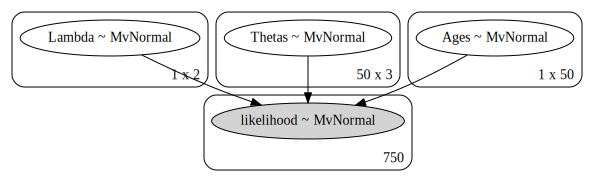

In [19]:
pm.model_to_graphviz(model1)

In [20]:
with model1:
    posterior_samples=pm.sample(draws=1000,cores=8,chains=8,tune=1000)#,step=pm.HamiltonianMC())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [Ages, Thetas, Lambda]
Sampling 8 chains:   1%|          | 103/16000 [00:04<12:46, 20.73draws/s]


ValueError: Not enough samples to build a trace.

In [ ]:
import pickle
pickle.dump(posterior_samples,open("posterior_samples_pymc3.pkl","wb"))

In [21]:
import pickle
posterior_samples=pickle.load(open("posterior_samples_pymc3.pkl","rb"))

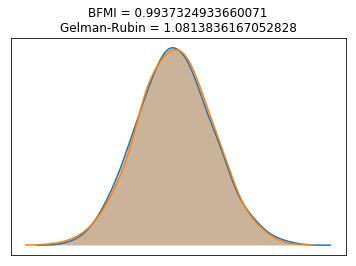

In [22]:
bfmi = pm.bfmi(posterior_samples)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(posterior_samples).values())

(pm.energyplot(posterior_samples, legend=False, figsize=(6, 4))
     .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe800f8be0>,
      dtype=object)

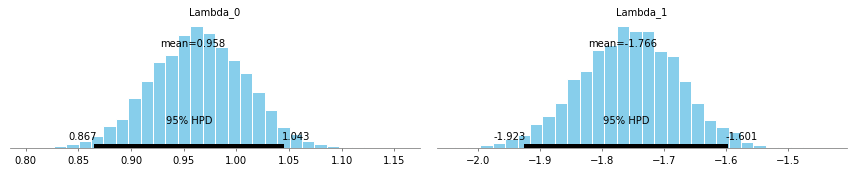

In [23]:
pm.plot_posterior(posterior_samples,varnames=['Lambda'])

In [24]:
post_lambda=posterior_samples.get_values('Lambda')
post_ages=posterior_samples.get_values('Ages')
post_thetas=posterior_samples.get_values('Thetas')

In [25]:
alpha_imf=post_lambda[:,:,0]*norm_widths[0]+norm_means[0]
log10_N1a=post_lambda[:,:,1]*norm_widths[1]+norm_means[1]

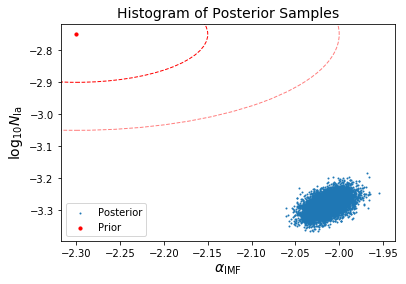

In [26]:
prior_ellipse=matplotlib.patches.Ellipse([norm_means[0],norm_means[1]],norm_widths[0],norm_widths[1],fill=False,\
                                         linewidth=1,color='r',linestyle='--')
prior_ellipse_2=matplotlib.patches.Ellipse([norm_means[0],norm_means[1]],2*norm_widths[0],2*norm_widths[1],fill=False,\
                                         linewidth=1,color='r',linestyle='--',alpha=0.5)

plt.scatter(alpha_imf,log10_N1a,s=1,label='Posterior');FS=14
plt.scatter(norm_means[0],norm_means[1],label='Prior',c='r',s=10)
plt.ylabel(r'$\log_{10}N_\mathrm{Ia}$',fontsize=FS);
plt.legend();
plt.xlabel(r'$\alpha_\mathrm{IMF}$',fontsize=FS)
plt.title(r'Histogram of Posterior Samples',fontsize=FS);
ax=plt.gca()
ax.add_patch(prior_ellipse)
ax=plt.gca()
ax.add_patch(prior_ellipse_2);

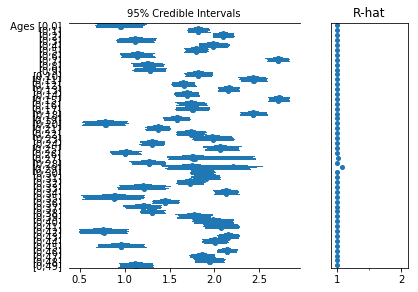

In [27]:
pm.forestplot(posterior_samples, varnames=['Ages']);

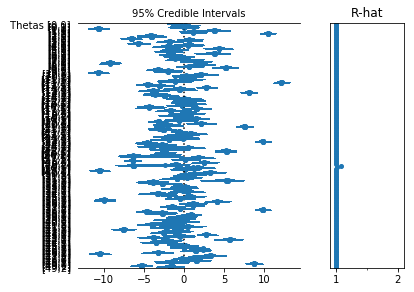

In [28]:
pm.forestplot(posterior_samples,varnames=['Thetas'])

In [29]:
pm.summary(posterior_samples,varnames=['Lambda'])

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Lambda__0_0,0.958180,0.045298,0.000652,0.867232,1.043322,6031.803186,1.000028
Lambda__0_1,-1.766326,0.081760,0.002397,-1.922529,-1.600812,978.833020,1.003681


#### Corner Plot of $\Lambda$ Posteriors

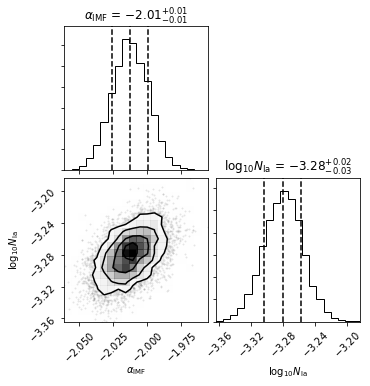

In [30]:
import corner
samples = np.hstack([alpha_imf,log10_N1a])#.T
names=[r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$']
corner.corner(samples,quantiles=[0.17,0.5,0.83],show_titles=True,labels=names,truths=Lambda_prior_mu,use_math_text=True);#, truths=true_params);



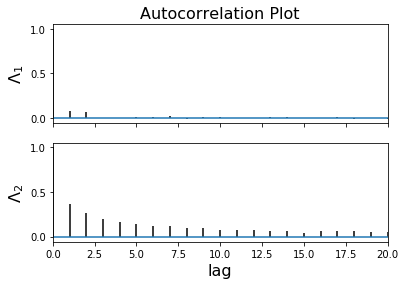

In [31]:
burn_in=1000
maxlags=20
FS=16
lambda_samples=posterior_samples['Lambda'][:,0,:][burn_in:]
fig,ax=plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
for l,lam in enumerate(lambda_samples.T):
    ax[l].acorr(lam, detrend=plt.mlab.detrend_mean,maxlags=maxlags)
    ax[l].set_ylabel(r"$\Lambda_{%d}$"%(l+1),fontsize=FS)
    ax[l].set_xlim(0, maxlags)

ax[1].set_xlabel("lag",fontsize=FS)
ax[0].set_title("Autocorrelation Plot",fontsize=FS);    

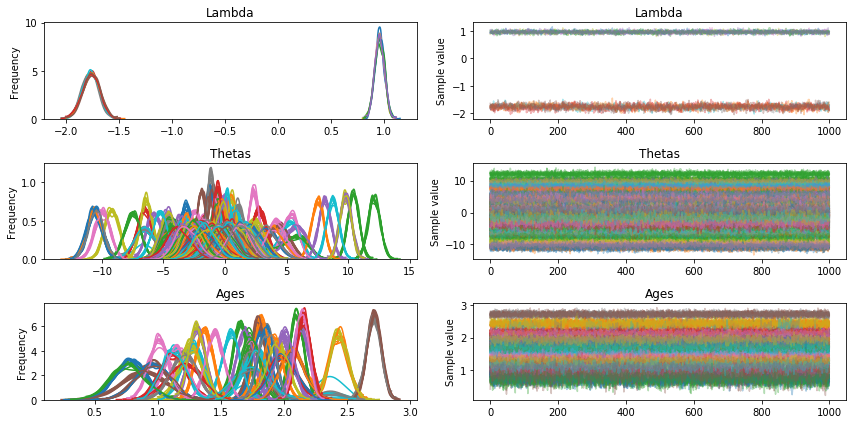

In [32]:
pm.traceplot(posterior_samples);

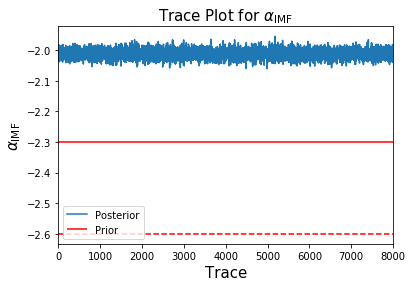

In [33]:
plt.plot(alpha_imf,label='Posterior');FS=15
plt.hlines(norm_means[0],0,len(alpha_imf),color='r',label='Prior')
plt.hlines(norm_means[0]-norm_widths[0],0,len(alpha_imf),color='r',linestyles='--')
plt.hlines(norm_means[0]+norm_widths[0],0,len(alpha_imf),color='r',linestyles='--')
plt.xlim([0,len(alpha_imf)]);plt.legend()
plt.ylabel(r'$\alpha_\mathrm{IMF}$',fontsize=FS)
plt.xlabel(r'Trace',fontsize=FS);
plt.title(r'Trace Plot for $\alpha_\mathrm{IMF}$',fontsize=FS);

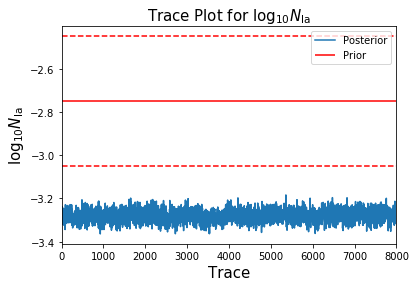

In [34]:
plt.plot(log10_N1a,label='Posterior');FS=15
plt.hlines(norm_means[1],0,len(log10_N1a),color='r',label='Prior')
plt.hlines(norm_means[1]-norm_widths[1],0,len(log10_N1a),color='r',linestyles='--')
plt.hlines(norm_means[1]+norm_widths[1],0,len(log10_N1a),color='r',linestyles='--')
plt.xlim([0,len(log10_N1a)]);plt.legend()
#plt.xlim([20000,25000])
plt.ylabel(r'$\log_{10}N_\mathrm{Ia}$',fontsize=FS)
plt.xlabel(r'Trace',fontsize=FS);
plt.title(r'Trace Plot for $\log_{10}N_\mathrm{Ia}$',fontsize=FS);

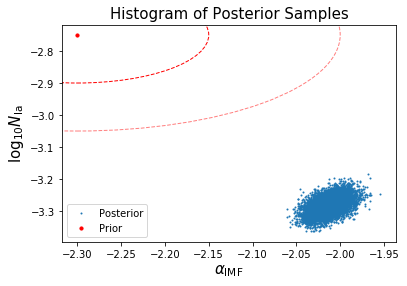

In [35]:
prior_ellipse=matplotlib.patches.Ellipse([norm_means[0],norm_means[1]],norm_widths[0],norm_widths[1],fill=False,\
                                         linewidth=1,color='r',linestyle='--')
prior_ellipse_2=matplotlib.patches.Ellipse([norm_means[0],norm_means[1]],2*norm_widths[0],2*norm_widths[1],fill=False,\
                                         linewidth=1,color='r',linestyle='--',alpha=0.5)

plt.scatter(alpha_imf,log10_N1a,s=1,label='Posterior')
plt.scatter(norm_means[0],norm_means[1],label='Prior',c='r',s=10)
plt.ylabel(r'$\log_{10}N_\mathrm{Ia}$',fontsize=FS);
plt.legend();
plt.xlabel(r'$\alpha_\mathrm{IMF}$',fontsize=FS)
plt.title(r'Histogram of Posterior Samples',fontsize=FS);
ax=plt.gca()
ax.add_patch(prior_ellipse)
ax=plt.gca()
ax.add_patch(prior_ellipse_2);